In [1]:
import os
import numpy as np
import rasterio
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from glob import glob
#import seaborn as sns
from tifffile import imread
import tifffile as tiff
from pathlib import Path
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatablef
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
from matplotlib import font_manager as fm
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
font_path = Path.home() / ".fonts" / "Arial.ttf"
arial_font = fm.FontProperties(fname=str(font_path))

# Register it as a global font
fm.fontManager.addfont(str(font_path))

# Set as global default by name
plt.rcParams['font.family'] = arial_font.get_name()
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['lines.linewidth'] = 2.5


#plt.rcParams['mathtext.rm'] = 'sans'
#plt.rcParams['mathtext.it'] = 'sans:italic'
#plt.rcParams['mathtext.bf'] = 'sans:bold'

SMALL_SIZE = 14
MEDIUM_SIZE =13
BIGGER_SIZE = 18
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=(MEDIUM_SIZE),title_fontsize = MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:

#path to predictions to be plotted in fig b)
tessera_path = "/m/cs/scratch/networks/silja/forests/btfm_project/efm/predictions_clipped_mse/seed42/fraction_1.0/" 
sota_path = "/m/cs/scratch/networks/silja/forests/the-biomassters/1st-place/preds_ots/" #biomassters winner
spectralgpt_path = "/m/cs/scratch/networks/silja/forests/btfm_project/pangaea/pangaea-bench/predictions_mse_clipped/1.0_seed42/predictions_fraction_test_1.0/"
gse_path = "/m/cs/scratch/networks/silja/forests/btfm_project/efm/predictions_clipped_mse/seed42/fraction_1.0/" #alpha eart (previously Google Gatellite embedding)
gt_dir = "../data/gt_dir_example" #"/m/cs/scratch/networks/silja/forests/btfm_project/ground_truth_clipped/test_agbm/" #ground truth test set


## path to tessera predictions plotted in figs c) and d)
tessera01_dir = "../data/tessera01_dir_example" #"/m/cs/scratch/networks/silja/forests/btfm_project/tessera/predictions_clipped_mse/seed42/fraction_0.1/"


figure_dir = "../figs"

In [5]:
#Fig a



75.80701448263828
fracs: [0.7580701448263828, 3.790350724131914, 7.580701448263828, 15.161402896527656, 22.742104344791485, 30.322805793055313, 37.90350724131914, 75.80701448263828]
frac
0.01    30.976096
0.05    28.666585
0.10    28.088161
0.20    27.657562
0.30    27.419302
0.40    27.174185
0.50    27.056250
1.00    26.614897
Name: val, dtype: float64
fracs: [0.7580701448263828, 3.790350724131914, 7.580701448263828, 15.161402896527656, 22.742104344791485, 30.322805793055313, 37.90350724131914, 75.80701448263828]
fracs: [0.7580701448263828, 3.790350724131914, 7.580701448263828, 15.161402896527656, 22.742104344791485, 30.322805793055313, 37.90350724131914, 75.80701448263828]
frac
0.01    32.070807
0.05    30.449552
0.10    29.429070
0.20    28.749855
0.30    28.406277
0.40    28.069772
0.50    27.858898
1.00    27.358676
Name: val, dtype: float64
frac
0.01    76.622168
0.05    36.868714
0.10    36.371139
0.20    35.228775
0.30    34.148720
0.40    33.543736
0.50    33.005598
1.00    3

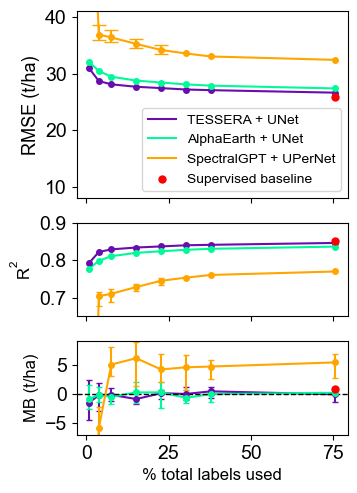

In [21]:
os.makedirs(figure_dir, exist_ok=True)

def get_marker_radius_y(ax, markersize_points):
    """
    Convert marker size in points to data units along y-axis.
    """
    fig = ax.get_figure()
    fig.canvas.draw()  # ensure bbox info is up-to-date
    bbox = ax.get_window_extent()

    # Get axis height in pixels
    height_px = bbox.height

    # y-axis range in data coordinates
    y0, y1 = ax.get_ylim()
    yrange = abs(y1 - y0)

    # Convert marker size from points to pixels
    # 1 point = 1/72 inch, so marker size in pixels is:
    marker_px = markersize_points * fig.dpi / 72

    # Now convert marker height in pixels to y-data units
    marker_data_y = (marker_px / height_px) * yrange
    return marker_data_y / 2  # return radius



def plot_restricted_labels_bars(base_dirs, labels, colors, ylims_a=None,plot_sota = False, extras = [None,None], plot_box = False):
    
    fig1, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(3.5, 5.5), sharex=True, gridspec_kw={"height_ratios": [2, 1, 1]})
    #fig2, [ax2, ax3] = plt.subplots(2, 1, figsize=(4, 2.5), sharex=True)

    axs = [ax1, ax2, ax3]
    line_width = 1.5
    markersize = 4

    metric_files = {
        "rmse": ax1,
        "r2": ax2,
        "mb": ax3,}

    #sota_RMSE = 27.492342 
    #sota_R2 = 0.83190286
    #sota_mb = -0.65727735

    sota_RMSE = 25.93727 
    sota_R2 = 0.8530164 
    sota_mb = -0.54855865

    #these are vs non-clipped ground truth
    #sota_RMSE = 27.486525 
    #sota_R2 = 0.8319522 
    #sota_mb = -0.6109937
    
    n_tot = 2773+8689
    sota_frac = 100*8689/n_tot
    print(sota_frac)

    for i, base in enumerate(base_dirs):

        label = labels[i]
        extra  = extras[i]
        
        for metric, ax in metric_files.items():

            if extra == None:
                path = os.path.join(base, f"{metric}_results.csv")
            else:
                path = os.path.join(base, f"{metric}_" + extra + "results.csv")
            df = pd.read_csv(path)

            grouped = df.groupby("frac")["val"]
            fracs = sorted(grouped.groups.keys())
            fracs = [100 * frac*8689/n_tot for frac in fracs]
            if i == 0:
                print("fracs:", fracs)
            #fracs = [100*frac for frac in fracs]
            mean = grouped.mean()
            min_ = grouped.min()
            max_ = grouped.max()

            # Set axis limits before computing marker radius
            if metric == "rmse":
                ax.set_ylim(ylims_a if ylims_a else (10, 42))
            elif metric == "r2":
                ax.set_ylim(0.65, 0.9)
            elif metric == "mb":
                ax.set_ylim(-7, 7)
            #fig2.canvas.draw()  # make sure it's up to date

            radius_y = get_marker_radius_y(ax, markersize)

            # Draw line connecting means
            if metric == "rmse":
                print(mean)
                ax.plot(fracs, mean, color=colors[i], linewidth=line_width, zorder=2, label=label)
            else:
                ax.plot(fracs, mean, color=colors[i], linewidth=line_width, zorder=2)

            if metric == "rmse":
                capp = 5
            else:
                capp = 2
            for x, m, lo, hi in zip(fracs, mean, min_, max_):
                err_lo = m - lo
                err_hi = hi - m
                show_bar = err_lo > radius_y or err_hi > radius_y

                ax.plot(x, m, color=colors[i], marker="o", markersize=markersize, zorder=3)

                if show_bar:
                    ax.errorbar(x, m, yerr=[[err_lo], [err_hi]], fmt='none',
                                color=colors[i], linewidth=line_width, capsize=capp, zorder=1)

    if plot_sota == True:
        sota_size = 25
        sota_color = "red"
        axs[0].scatter([sota_frac],[sota_RMSE],label = "Supervised baseline",color= sota_color,s=sota_size,zorder = 3)
        axs[1].scatter([sota_frac],[sota_R2],color= sota_color,s=sota_size,zorder = 3) #,label = "Biomassters winner",color="crimson",s=23)
        axs[2].scatter([sota_frac],[sota_R2],color= sota_color,s=sota_size,zorder = 3)

    
    ax1.set_ylabel("RMSE (t/ha)")
    ax1.set_ylim(8,41)
    ax3.set_ylim(-7,9)
    ax2.set_ylabel(r"$R^2$",fontsize=12)
    ax3.set_ylabel("MB (t/ha)",fontsize=12)
    ax1.legend(fontsize=10, loc="lower right")

    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)

    #ax1.set_xlabel("% total labels used")
    ax3.set_xlabel("% total labels used", fontsize=12)

    #fig2.subplots_adjust(wspace=0.1, hspace=0.1)
    #fig2.align_ylabels()

    fig1.savefig(figure_dir + "/rmse_fig.pdf", bbox_inches="tight")
    #fig2.savefig("agb_efms_r2_mb.pdf", bbox_inches="tight")

#path1 = "/m/cs/scratch/networks/silja/forests/btfm_project/tessera/predictions/results/"
path1 = "../data/metrics/tessera/"
path2 = "../data/metrics/alpha_earth/"
path3 = "../data/metrics/spectralgpt/"

labels = ["TESSERA + UNet",  "AlphaEarth + UNet", "SpectralGPT + UPerNet", "Supervised baseline"]
colors = ["#6a0dad","mediumspringgreen", "orange"]

#ylims_a=[22,37]
plot_restricted_labels_bars([path1, path2, path3],labels,colors, plot_sota=True, extras = ["", "", ""]) #, path2])

In [24]:
#fig b)

In [ ]:
"""
#Code for calculating the .npz-files under data/binned_stats/

def compute_means_from_raw(true_all, pred_all, bin_edges):
    
    bins = len(bin_edges) - 1
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    true_all = np.asarray(true_all).ravel()
    pred_all = np.asarray(pred_all).ravel()
    bin_idx = np.digitize(true_all, bin_edges) - 1  # 0-based

    means = np.full(bins, np.nan)
    stds = np.full(bins, np.nan)
    counts = np.zeros(bins, dtype=int)

    for i in range(bins):
        mask = bin_idx == i
        if np.any(mask):
            means[i] = np.mean(pred_all[mask])
            stds[i] = np.std(pred_all[mask])
            counts[i] = np.sum(mask)

    return bin_centers, means, stds, counts



def compute_and_save_results(pred_dirs, gt_dir, common_names, bin_edges, out_dir, tifs):
    
    os.makedirs(out_dir, exist_ok=True)

    for i, (label, pred_dir) in enumerate(pred_dirs.items()):
        print(f"Processing: {label}")
        tif = tifs[i]
        all_true = []
        all_pred = []

        for name in sorted(common_names):
            if tif:
                pred = tiff.imread(os.path.join(pred_dir, name.replace(".npy", ".tif"))).astype(np.float32)
            else:
                pred = np.load(os.path.join(pred_dir, name)).astype(np.float32)
            true = np.load(os.path.join(gt_dir, name)).astype(np.float32)

            all_true.append(true.ravel())
            all_pred.append(pred.ravel())

        true_concat = np.concatenate(all_true)
        pred_concat = np.concatenate(all_pred)

        bin_centers, mean_pred, std_pred, gt_counts = compute_means_from_raw(true_concat, pred_concat, bin_edges)
        
        np.savez_compressed(
            os.path.join(out_dir, f"{label}_binned_stats.npz"),
            bin_centers=bin_centers,
            mean=mean_pred,
            std=std_pred,
            gt_counts=gt_counts
        )




pred_dirs = {
    "TESSERA": tessera_path,
    "Supervised baseline": sota_path,
    "SpectralGPT": spectralgpt_path,
    "GSE": gse_path
}

common_names = sorted(set(os.listdir(pred_dirs["TESSERA"])) & set(os.listdir(gt_dir)))

compute_and_save_results(pred_dirs, gt_dir, common_names,
                         bin_edges=np.linspace(0, 500, 101),
                         out_dir="../data/binned_stats/",
                         tifs=[False, True, False, False])

"""

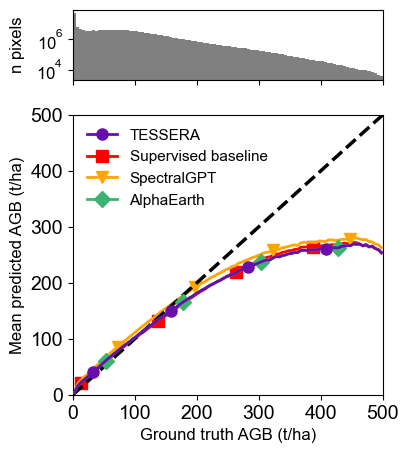

In [22]:
def plot_binned_stats(model_labels, stats_dir, max_agbm, bins):
    
    bin_edges = np.linspace(0, max_agbm, bins + 1)

    color_map = {
        "TESSERA": "#6a0dad",
        "GSE": "mediumseagreen",
        "SpectralGPT": "orange",
        "Supervised baseline": "red"
    }
    marker_map = {
        "TESSERA": "o",
        "GSE": "D",
        "SpectralGPT": "v",
        "Supervised baseline": "s"
    }

    fig = plt.figure(figsize=(4, 5))
    gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.2)

    ax0 = fig.add_subplot(gs[0])
    first = True
    all_results = {}

    for label in model_labels:
        data = np.load(os.path.join(stats_dir, f"{label}_binned_stats.npz"))
        bin_centers = data["bin_centers"]
        mean = data["mean"]
        std = data["std"]
        gt_counts = data["gt_counts"]
        all_results[label] = (bin_centers, mean, std, gt_counts)

        if first:
            valid = gt_counts > 0
            ax0.bar(bin_centers[valid], gt_counts[valid], width=bin_edges[1]-bin_edges[0],
                    color='gray', edgecolor='none')
            ax0.set_ylabel("n pixels", fontsize=12)
            ax0.set_yscale("log")
            ax0.set_yticks([1e4, 1e6])
            ax0.set_yticklabels([r"$10^4$", r"$10^6$"], fontsize=12)
            ax0.set_xlim(0, max_agbm)
            ax0.tick_params(axis='x', which='both', labelbottom=False)
            first = False

    ax = fig.add_subplot(gs[1], sharex=ax0)
    linew = 2
    msize = 8
    #markevery = (5, 25)
    #ax.set_yscale("log")
    indd = 0
    zorders = [5,1,2,3]
    markevery = 25
    markeverys = [(6,markevery), (2,markevery), (14,markevery),(10,markevery)]
    for label, (bin_centers, mean_preds, _, _) in all_results.items():
        valid = ~np.isnan(mean_preds)

        if label == "GSE":
            labell="AlphaEarth"
        else:
            labell = label
        ax.plot(bin_centers[valid], mean_preds[valid],
                label=labell,
                color=color_map.get(label, None),
                marker=marker_map.get(label, None),
                linewidth=linew,
                markersize=msize,zorder = zorders[indd],markevery=markeverys[indd])
        
        indd += 1

    ax.plot([0, max_agbm], [0, max_agbm], 'k--')
    ax.set_xlabel("Ground truth AGB (t/ha)", fontsize=12)
    ax.set_ylabel("Mean predicted AGB (t/ha)", fontsize=12)
    ax.set_xlim(0, max_agbm)
    ax.set_ylim(0, max_agbm)
   
    ax.legend(frameon=False, fontsize=11, loc="upper left")

    fig.align_ylabels()
    #fig.tight_layout()
    plt.savefig(figure_dir + "/binned_scatter_with_raw_means.pdf", dpi=300, bbox_inches="tight")
    plt.show()


plot_binned_stats(
    model_labels=["TESSERA", "Supervised baseline", "SpectralGPT", "GSE"],
    stats_dir="../data/binned_stats/",
    max_agbm=500,
    bins=100
)

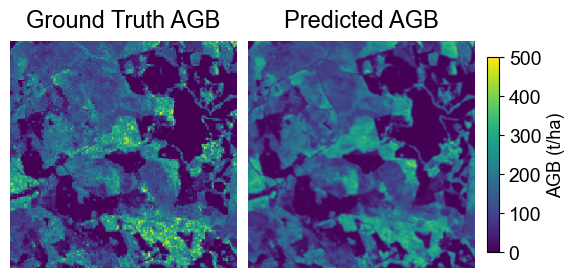

In [23]:
#fig c

def plot_example(true, pred, title='Example AGBM Prediction', save_path=None):
    
    vmin = np.nanmin([true, pred])
    vmax = np.nanmax([true, pred])

    fsize = 17
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    titlepad = 10

    cmap = "viridis"
    im0 = axes[0].imshow(true, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title("Ground Truth AGB", pad=titlepad,fontsize=fsize)
    axes[0].axis("off")

    im1 = axes[1].imshow(pred, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title("Predicted AGB", pad=titlepad, fontsize=fsize)
    axes[1].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.17, 0.02, 0.65])
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_label("AGB (t/ha)")

    #fig.suptitle(title, fontsize=12)
    plt.subplots_adjust(wspace=0.05, right=0.9)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


name = "86ec7fe7_agbm.npy"

true = np.load(os.path.join(gt_dir, name))
pred = np.load(os.path.join(tessera01_dir, name))
plot_example(true, pred, title=name, save_path= figure_dir + "/agbm_example_tessera.pdf")

In [7]:
#Fig d

"""
#Code for calculating the files hist2d_tessera_10.npy and hist2d_sota.npy under binned_stats/

max_agbm = 500 #10267.56
bins = 100
bin_edges = np.linspace(0, max_agbm, bins + 1)


for pred_dir, outfile in zip([tessera01_dir, sota_path], ["hist2d_tessera_10.npy", "hist2d_sota.npy"]):

    hist2d = np.zeros((bins, bins), dtype=np.int64)

    if pred_dir == tessera01_dir:
        pred_files = sorted(glob(os.path.join(pred_dir, "*.npy")))
        gt_files = sorted(glob(os.path.join(gt_dir, "*.npy")))
        print(len(pred_files), len(gt_files))
        tif = False
    else:
        pred_files = sorted(glob(os.path.join(pred_dir, "*.tif")))
        gt_files = sorted(glob(os.path.join(gt_dir, "*.npy")))
        print(len(pred_files), len(gt_files))
        tif = True

    # Ensure matched filenames
    common_names = ({Path(f).stem for f in pred_files} & {Path(f).stem for f in gt_files})
    #common_names = set(os.path.basename(f) for f in pred_files) & set(os.path.basename(f) for f in gt_files)
    print(f"Using {len(common_names)} matched prediction/target pairs")
    
    for name in sorted(common_names):
    
        if tif == True:
            pred  = tiff.imread(os.path.join(pred_dir, name+".tif")).astype(np.float32)
            #true  = tiff.imread(os.path.join(gt_dir, name)).astype(np.float32)
        else:
            pred = np.load(os.path.join(pred_dir, name+".npy")).astype(np.float32)
        true = np.load(os.path.join(gt_dir, name + ".npy")).astype(np.float32)
    
        pred = pred.ravel()
        true = true.ravel()
    
        if np.any(pred < 0):
            print(f"Warning: Prediction values out of range! "
                  f"min={pred.min()}, max={pred.max()}, allowed=[0, {max_agbm}]")
    
        # Optionally clip if needed
        # pred = np.clip(pred, 0, max_agbm)
        # true = np.clip(true, 0, max_agbm)
    
        # Bin indices (0-based)
        true_idx = np.digitize(true, bin_edges) - 1
        pred_idx = np.digitize(pred, bin_edges) - 1
    
        # Create mask for valid bin pairs
        valid = (true_idx >= 0) & (true_idx < bins) & (pred_idx >= 0) & (pred_idx < bins)
    
        # Fast histogram update using NumPy's in-place accumulator
        np.add.at(hist2d, (pred_idx[valid], true_idx[valid]), 1)
    
    #np.save("hist2d_sota.npy", hist2d)
    np.save("../data/binned_stats/" + outfile, hist2d)

"""

'\nmax_agbm = 500 #10267.56\nbins = 100\nbin_edges = np.linspace(0, max_agbm, bins + 1)\n\n\nfor pred_dir, outfile in zip([tessera01_dir, sota_path], ["hist2d_tessera_10.npy", "hist2d_sota.npy"]):\n\n    hist2d = np.zeros((bins, bins), dtype=np.int64)\n\n    if pred_dir == tessera01_dir:\n        pred_files = sorted(glob(os.path.join(pred_dir, "*.npy")))\n        gt_files = sorted(glob(os.path.join(gt_dir, "*.npy")))\n        print(len(pred_files), len(gt_files))\n        tif = False\n    else:\n        pred_files = sorted(glob(os.path.join(pred_dir, "*.tif")))\n        gt_files = sorted(glob(os.path.join(gt_dir, "*.npy")))\n        print(len(pred_files), len(gt_files))\n        tif = True\n\n    # Ensure matched filenames\n    common_names = ({Path(f).stem for f in pred_files} & {Path(f).stem for f in gt_files})\n    #common_names = set(os.path.basename(f) for f in pred_files) & set(os.path.basename(f) for f in gt_files)\n    print(f"Using {len(common_names)} matched prediction/target

45231359
max 45231359


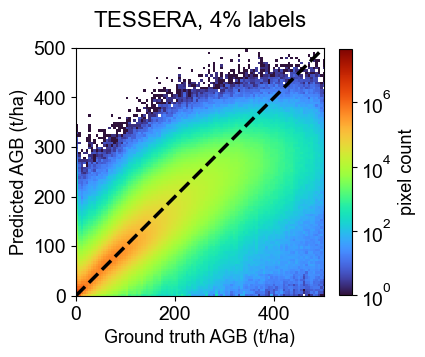

47626960
max 47626960


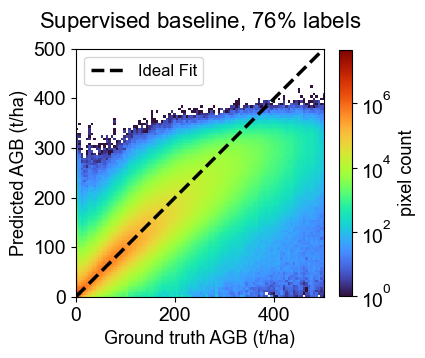

In [24]:
def plot_heatmap(arr_path, fname, title, max_agbm = 500, plot_legend = True, figname = "heatmap.pdf"):

    maxx = 47626960
    #if tessera == True:
    hist2d = np.load(arr_path + fname ) #hist2d_tessera.npy")
    #else:
        #hist2d = np.load(arr_path + "hist2d_biomassters.npy")
    print(max(hist2d.flatten()))
    plt.figure(figsize=(4, 4))
    plt.imshow(
        hist2d,
        origin='lower',
        extent=[0, max_agbm, 0, max_agbm],
        aspect='equal',
        cmap='turbo',
        interpolation='nearest',
        norm=mcolors.LogNorm(vmax=maxx, vmin=1)  # <- log scale
    )
    print("max", hist2d.max())
    plt.plot([0, max_agbm], [0, max_agbm], 'k--', label='Ideal Fit')
    cbar = plt.colorbar(label='pixel count',shrink=0.8)
    plt.xlabel("Ground truth AGB (t/ha)")
    plt.ylabel("Predicted AGB (t/ha)")  #(Mg/ha)")
    plt.ylim(0,500)
    plt.xlim(0,500)
    #plt.title(f"2D Histogram of AG#BM Predictions\n$R^2$ = {r2:.2f}")
    if plot_legend == True:
        plt.legend(fontsize=12)
    #plt.grid(True)
    #plt.tight_layout()
    #if tessera == True:
    plt.title(title, fontsize=16, pad =15)
    #plt.title("TESSERA, 10% training labels",fontsize=13)
    #figname = "heatmap_tessera.png"
    
    #else:
    #plt.title("Biomassters winner",fontsize=13)
    #figname = "heatmap_bwinner.png"
        
    plt.savefig(figure_dir + "/"+figname,bbox_inches="tight")
    plt.show()


arr_path = "../data/binned_stats/" #path to hist2d files
plot_heatmap(arr_path, "hist2d_tessera_10.npy", "TESSERA, " + r"$4\%$" + " labels",plot_legend =False, figname = "heatmap_tessera.pdf")
plot_heatmap(arr_path, "hist2d_sota.npy", "Supervised baseline, " + r"$76\%$" + " labels", figname = "heatmap_sota.pdf")